# Imports

In [173]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import zscore
import scipy.stats as stats
from scipy.stats import chi2_contingency
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, auc
from mlxtend.evaluate import permutation_test
import statsmodels.api as sm

In [205]:
df_cat = pd.read_csv('./data/data_categorielles (1).csv')
df_num = pd.read_csv('./data/var_num.csv')
df_app = pd.read_csv('./data/application_train_vf.csv')

In [245]:
df_app[df_app['CODE_GENDER']=='F']['TARGET'].mean()

0.06640214264457892

# Preprocessing

In [247]:
data = pd.concat([df_num,df_cat],axis = 1)

In [248]:
data['date'] = df_app['date_mensuelle'].copy()

In [249]:
data['date'] = pd.to_datetime(data['date'])

In [250]:
data.drop(columns = ['Unnamed: 0','NAME_HOUSING_TYPE','AMT_ANNUITY_disc_int'],inplace = True)
data['CODE_GENDER'] = data['CODE_GENDER'].apply(lambda x : 'F' if x == 'XNA' else x)

# Encoding

In [251]:
for col in data.select_dtypes(include = 'object').columns:
    print(f"{col} : {data[col].nunique()}")

DAYS_BIRTH_disc_int : 3
EXT_SOURCE_2_disc_int : 3
AMT_GOODS_PRICE_disc_int : 2
REGION_POPULATION_RELATIVE_disc_int : 2
DAYS_EMPLOYED_disc_int : 2
DAYS_REGISTRATION_disc_int : 2
EXT_SOURCE_3_disc_int : 2
AMT_CREDIT_disc_int : 2
NAME_CONTRACT_TYPE : 2
CODE_GENDER : 2
FLAG_OWN_CAR : 2
FLAG_OWN_REALTY : 2
NAME_INCOME_TYPE_discret : 2
NAME_EDUCATION_TYPE_discret : 2
NAME_FAMILY_STATUS_discret : 2


# Encoding

In [252]:
for col in data.select_dtypes(include = 'object').columns :
    print(f'{col} : {data[col].unique()}')

DAYS_BIRTH_disc_int : ['[-13537--7489]' '[-19303--13538]' '[-25229--19304]']
EXT_SOURCE_2_disc_int : ['[0.48-0.85]' '[0.0-0.15]' '[0.15-0.48]']
AMT_GOODS_PRICE_disc_int : ['[679500.0-4050000.0]' '[40500.0-676278.0]']
REGION_POPULATION_RELATIVE_disc_int : ['[0.0-0.03]' '[0.03-0.07]']
DAYS_EMPLOYED_disc_int : ['[-2443-365243]' '[-17912--2444]']
DAYS_REGISTRATION_disc_int : ['[-6170.0-0.0]' '[-24672.0--6171.0]']
EXT_SOURCE_3_disc_int : ['[0.32-0.9]' '[0.0-0.32]']
AMT_CREDIT_disc_int : ['[675000.0-4050000.0]' '[45000.0-674842.5]']
NAME_CONTRACT_TYPE : ['Cash loans' 'Revolving loans']
CODE_GENDER : ['M' 'F']
FLAG_OWN_CAR : ['Y' 'N']
FLAG_OWN_REALTY : ['Y' 'N']
NAME_INCOME_TYPE_discret : ['high_income' 'low_income']
NAME_EDUCATION_TYPE_discret : ['lower' 'higher']
NAME_FAMILY_STATUS_discret : ['couple' 'alone']


In [253]:
for col in data.select_dtypes(include='object').columns:
    one_hot_encoded = pd.get_dummies(data[col], prefix=col, drop_first=True)
    data = data.drop(col, axis=1)
    data = data.join(one_hot_encoded)

# Encoding boolean values as 1 for True and 0 for False
for col in data.select_dtypes(include=bool).columns:
    data[col] = data[col].astype(int)

# Train test split

In [281]:
X = data.drop(columns = ['TARGET', 'SK_ID_CURR'], axis=1).copy()
X = X[X['date']<'2020-01-01']
X = X[variables]
y = data[data['date']<'2020-01-01']['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)


In [282]:
X_train.drop(columns = ['date'],inplace = True)
X_test.drop(columns =['date'],inplace = True)

KeyError: "['date'] not found in axis"

# Test avec fonction de perte customisée

In [294]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

from sklearn.metrics import roc_auc_score


class_weight = {0: 1, 1: 1.8}  # Pénaliser plus fortement la classe 1 (positifs)



model = LogisticRegression(class_weight=class_weight)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)
print("Matrice de confusion:")
print(conf_matrix)

aucc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
print("AUC:", aucc)

Matrice de confusion:
[[49249   211]
 [ 3986   103]]
AUC: 0.7150284233824102


# LOGIT

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.24846808538489035
            Iterations: 90
            Function evaluations: 90
            Gradient evaluations: 90


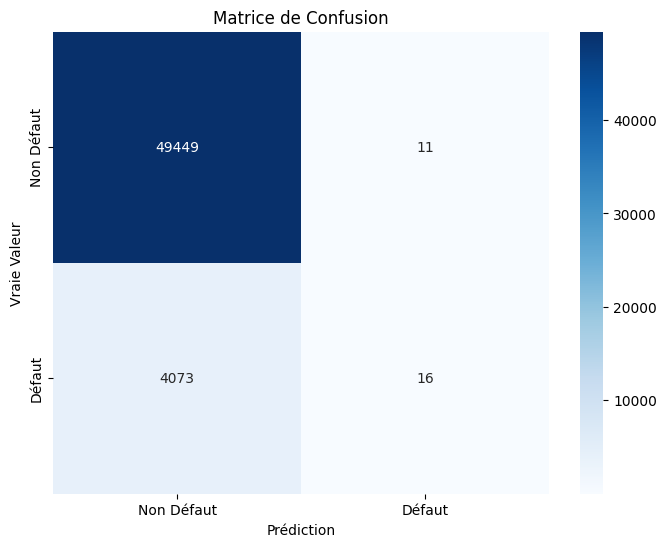

In [284]:
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


X_train_scaled = sm.add_constant(X_train)
X_test_scaled = sm.add_constant(X_test)

# Fit logistic regression model
model = sm.Logit(y_train, X_train_scaled)
result = model.fit_regularized(method='l1')

# Predictions on testing set
y_pred = result.predict(X_test_scaled)
y_pred = (y_pred > 0.5).astype(int)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=['Non Défaut', 'Défaut'], 
            yticklabels=['Non Défaut', 'Défaut'])
plt.xlabel('Prédiction')
plt.ylabel('Vraie Valeur')
plt.title('Matrice de Confusion')
plt.show()


# Résultats

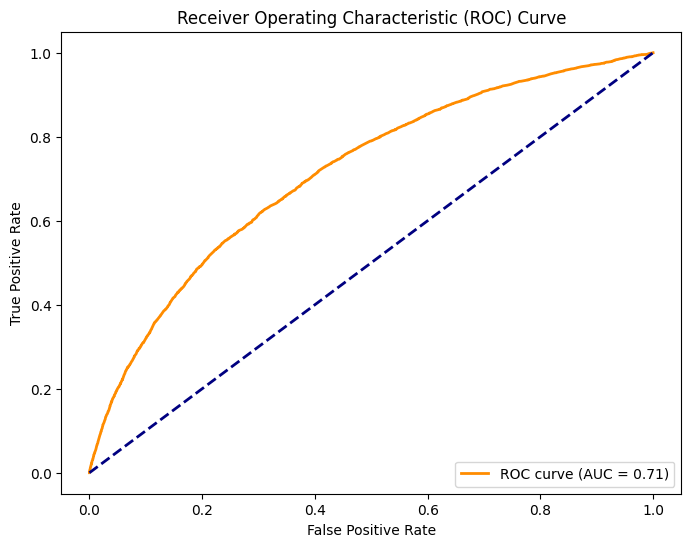

Coefficient de Gini: 0.4299989557062198


In [285]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

X_test_scaled = sm.add_constant(X_test)


y_prob = result.predict(X_test_scaled)


fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

y_prob = result.predict(X_test_scaled)

# Calculer le taux de faux positifs (FPR), le taux de vrais positifs (TPR) et les seuils
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculer l'aire sous la courbe ROC (AUC)
roc_auc = auc(fpr, tpr)

# Calculer le coefficient de Gini
gini_coefficient = 2 * roc_auc - 1
print("Coefficient de Gini:", gini_coefficient)

# Coefficients

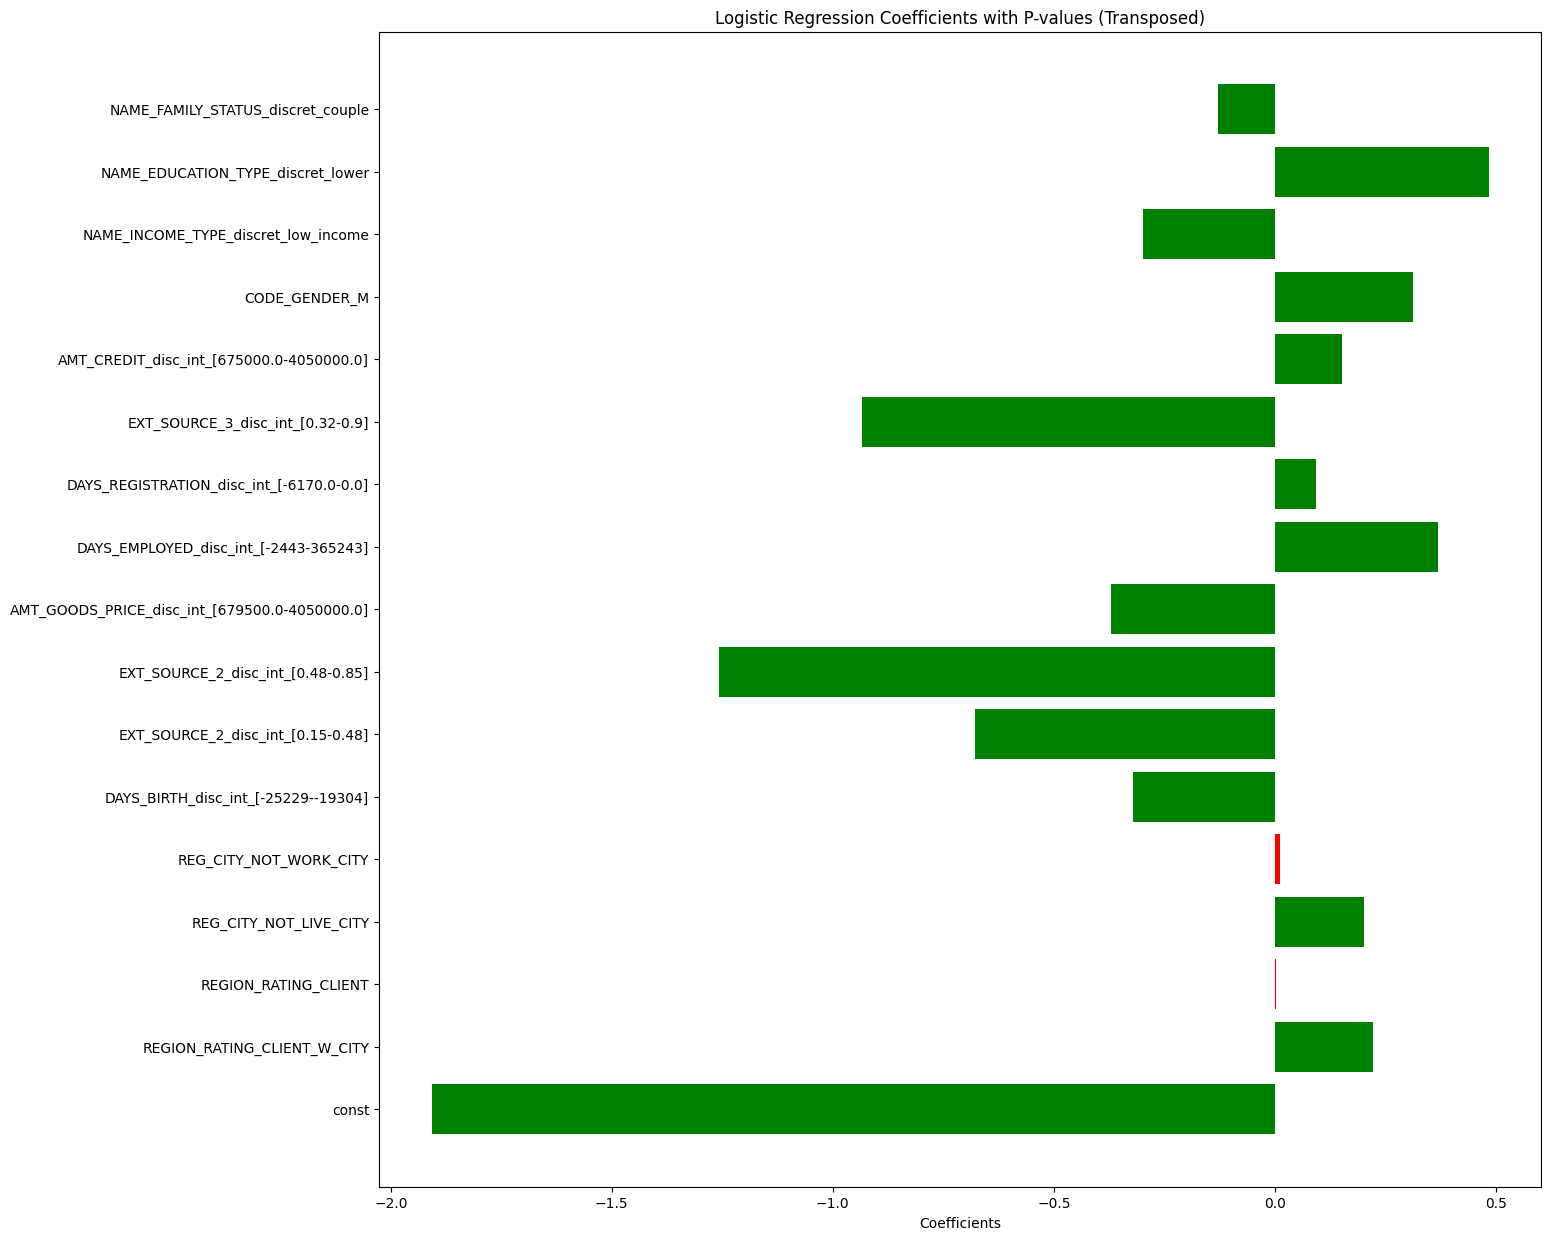

In [286]:
coefficients = result.params
pvalues = result.pvalues

var_signif = [variable for variable, p_value in zip(X_test_scaled.columns, pvalues) if p_value < 0.05]

# Plot des coefficients avec des couleurs différentes en fonction des p-values (transposé)
colors = ['red' if p > 0.05 else 'green' for p in pvalues]

plt.figure(figsize=(15, 15))
plt.barh(range(len(coefficients)), coefficients, color=colors)
plt.yticks(range(len(coefficients)), X_test_scaled.columns)
plt.xlabel('Coefficients')
plt.title('Logistic Regression Coefficients with P-values (Transposed)')
plt.show()

In [195]:
var_signif.pop(0)

'const'

# Selection de variables

In [262]:

liste_gini = []

for col in X.drop(columns = ['date']).columns : 
    X_train_scaled = X_train[col]
    X_test_scaled = X_test[col]
    X_train_scaled = sm.add_constant(X_train_scaled)
    X_test_scaled = sm.add_constant(X_test_scaled)
    
    # Fit logistic regression model
    model = sm.Logit(y_train, X_train_scaled)
    result = model.fit_regularized(method='l1')
    
    # Predictions on testing set
    y_pred = result.predict(X_test_scaled)
    y_pred = (y_pred > 0.5).astype(int)
    
    # Confusion matrix
    
    y_prob = result.predict(X_test_scaled)
    
    # Calculer le taux de faux positifs (FPR), le taux de vrais positifs (TPR) et les seuils
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    
    # Calculer l'aire sous la courbe ROC (AUC)
    roc_auc = auc(fpr, tpr)
    
    # Calculer le coefficient de Gini
    gini_coefficient = 2 * roc_auc - 1
    liste_gini.append(gini_coefficient)
df_selec_var = pd.DataFrame(liste_gini,index = X.drop(columns = ['date']).columns, columns =['Gini'] )

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.26808797710777393
            Iterations: 17
            Function evaluations: 18
            Gradient evaluations: 17
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.2681907272185137
            Iterations: 17
            Function evaluations: 18
            Gradient evaluations: 17
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.26953411905828667
            Iterations: 16
            Function evaluations: 16
            Gradient evaluations: 16
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.26936213748350873
            Iterations: 16
            Function evaluations: 16
            Gradient evaluations: 16
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.26897005075736596
            Iterations: 19
            Function

In [278]:
df_selec_var[df_selec_var['Gini']>0.05]

,Gini
REGION_RATING_CLIENT_W_CITY,0.100264
REGION_RATING_CLIENT,0.095870
REG_CITY_NOT_LIVE_CITY,0.051346
REG_CITY_NOT_WORK_CITY,0.086169
FLAG_EMP_PHONE,0.057721
DAYS_BIRTH_disc_int_[-25229--19304],0.087231
EXT_SOURCE_2_disc_int_[0.15-0.48],0.129340
EXT_SOURCE_2_disc_int_[0.48-0.85],0.230406
AMT_GOODS_PRICE_disc_int_[679500.0-4050000.0],0.090803
DAYS_EMPLOYED_disc_int_[-2443-365243],0.081693


In [280]:
variables = df_selec_var[df_selec_var['Gini']>0.05].drop('FLAG_EMP_PHONE').index.to_list()